**CELIK Baran 141 - Statistics & modeling - Lab session n°1**

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats as st 
from scipy.stats import t

# Introduction

Data about global temperatures are available from several sources. An easiest sources are  NASA, the National Climatic Data Center (NCDC) and the University of East Anglia in the UK. 
The NASA Goddard Space Flight Center is one source of global climate data. [To download data look at this page
](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series)


One key feature is the temperature anomaly.  The term global temperature anomaly means the difference in temperature with respect to a reference value or a long-term average. It is a very useful way of looking at the problem and in many ways better than absolute temperature. For example, a winter month may be colder than average in Washington DC, and also in Miami, but the absolute temperatures will be different in both places. [Look at this page for more details on the anomaly temperature](https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies)

In this lab we start from the raw data we will try to make some basic and statistical inference. The roadmap is to first work with global "land" data and then to work with land and ocean data measeured in Antartic for instance.  

In [6]:
!head land_global_data.csv

# Title: Global Land Average Temperature Anomalies
# Units: Degrees Celsius
# Base Period: 1901-2000
# Missing: -999
Date,Anomaly
185001,-1.27
185002,-0.54
185003,-0.47
185004,-0.96
185005,-0.81


In [7]:
!tail land_global_data.csv

202402,2.26
202403,2.12
202404,1.90
202405,1.62
202406,1.77
202407,1.73
202408,1.93
202409,1.93
202410,2.20
202411,2.31


We can split this data in two parts. The first one, the train, covers the first 150 years. The remaining part is held out subset and covers the most recent years. 


In [11]:
data = np.loadtxt(fname='land_global_data.csv',
              delimiter=',', skiprows=5)
print(data.shape)

# Take the 15 first years for train
# and the latest part for test
train = data[:150*12,:]
test  = data[150*12:,:]
Ntrain = train.shape[0]
Ntest = test.shape[0]

print(train.shape, test.shape)
print(train[:5])
print(train[-5:])

(2099, 2)
(1800, 2) (299, 2)
[[ 1.85001e+05 -1.27000e+00]
 [ 1.85002e+05 -5.40000e-01]
 [ 1.85003e+05 -4.70000e-01]
 [ 1.85004e+05 -9.60000e-01]
 [ 1.85005e+05 -8.10000e-01]]
[[1.99908e+05 6.10000e-01]
 [1.99909e+05 7.50000e-01]
 [1.99910e+05 5.70000e-01]
 [1.99911e+05 6.40000e-01]
 [1.99912e+05 8.90000e-01]]


# Preliminary data viz. 

Before diving into the regression analysis, it is important to explore the data visually and statistically. In this section, we begin by plotting the training data over time to identify any obvious trends and assess the distribution of temperature anomalies.

## Plot the training data

To start, we visualize the global temperature anomaly data over time, using the first 150 years as the training dataset. This allows us to identify any general trends, such as whether there is an increasing or decreasing temperature anomaly over the years.

In [111]:
# convert date column into datetime for plotting
def convert_date(x):
    year = int(x) // 100
    month = int(x) % 100
    return pd.Timestamp(year=year, month=month, day=1)

# extract date and anomaly from train
dates = [convert_date(d) for d in train[:, 0]]
anomalies = train[:, 1]

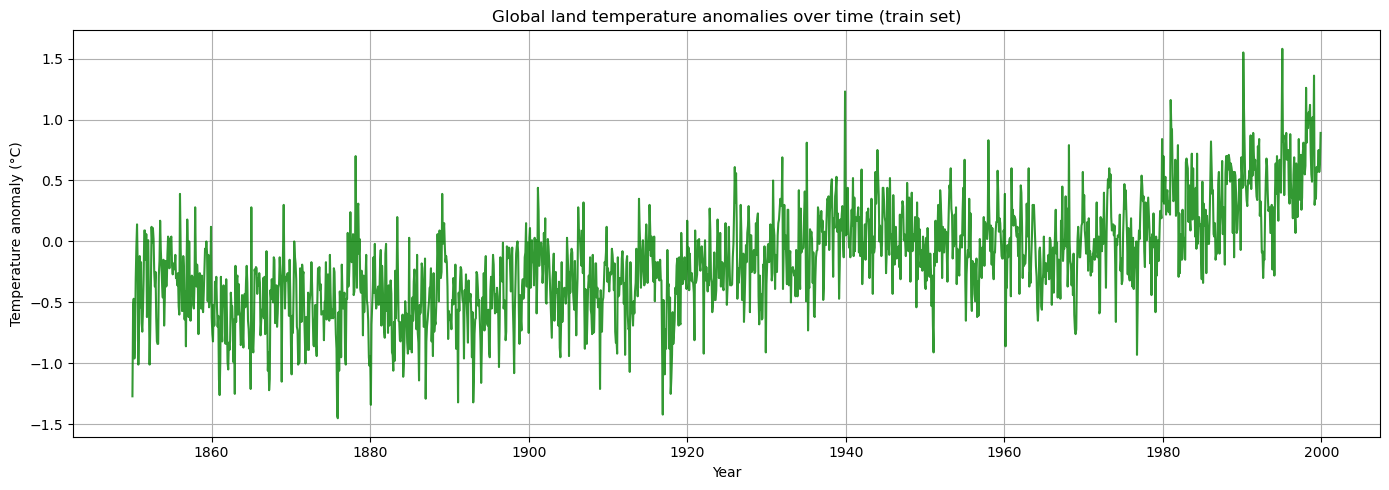

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(dates, anomalies, color='green',alpha=0.8)
plt.title('Global land temperature anomalies over time (train set)')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Histogram of temperature anomalies

Next, we examine the distribution of temperature anomalies. This helps us understand the distribution: is it symmetric? skewed? does it resemble a Gaussian? 

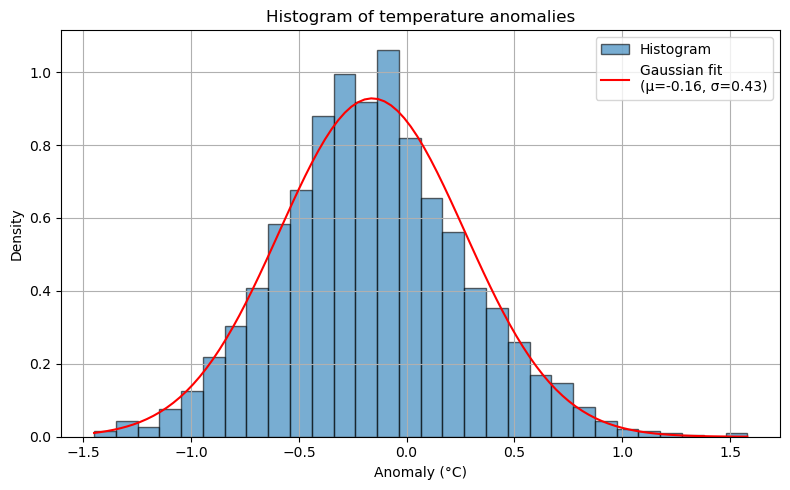

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(anomalies, bins=30, density=True, alpha=0.6, edgecolor='black', label='Histogram')

mu, sigma = np.mean(anomalies), np.std(anomalies)
x = np.linspace(min(anomalies), max(anomalies), 100)
plt.plot(x, st.norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian fit\n(μ={mu:.2f}, σ={sigma:.2f})')

plt.title('Histogram of temperature anomalies')
plt.xlabel('Anomaly (°C)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram shows the distribution of temperature anomalies. We compare the actual distribution to a Gaussian distribution by overlaying the probability density function.

## Gaussianity test

To statistically evaluate whether the temperature anomalies follow a normal distribution, we use the Shapiro-Wilk test. The null hypothesis of the test is that the data is normally distributed.

In [61]:
sample = anomalies
shapiro_test = st.shapiro(sample)

print("\nShapiro-Wilk test")
print("Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

alpha = 0.05 
if shapiro_test.pvalue < alpha:
    print("The p-value is below 0.05. We reject the null hypothesis: the data is not normally distributed.")
else:
    print("The p-value is above 0.05. We fail to reject the null hypothesis: the data may be normally distributed.")


Shapiro-Wilk test
Statistic: 0.9964030020475463
p-value: 0.00029855922499480756
The p-value is below 0.05. We reject the null hypothesis: the data is not normally distributed.


# Linear regression

In this section, we perform linear regression on the global temperature anomaly data to establish a model that explains the relationship between the temperature anomalies and time. We will compute the model parameters, visualize the results, and evaluate the model's performance using residual analysis.

## Compute weights using the normal equation

The first step is to compute the regression weights (intercept and slope) using the normal equation: $w=(X^{T}X)^{-1}X^Ty$, where:
- $X$ is the matrix of input features, with a column of ones for the intercept term.
- $y$ is the vector of observed temperature anomalies.
- $w$ is the vector of regression weights (intercept and slope).

This equation minimizes the sum of squared residuals between the observed anomalies and the predicted values.

In [67]:
def linear_regression(X, y):
    XTX = X.T @ X
    XTy = X.T @ y
    w = np.linalg.inv(XTX) @ XTy
    return w

We apply the above function to the training dataset to compute the weights:

In [70]:
X_train = np.column_stack((np.ones(Ntrain), train[:, 0]))
y_train = train[:, 1]

# fit model
w = linear_regression(X_train, y_train)
print("weights [intercept, slope]:", w)

weights [intercept, slope]: [-1.24354430e+01  6.37804947e-05]


- Intercept: $−12,4$
- Slope: $6.38*10^{-5}$

## Visualization of model fit on training and test sets

Next, we visualize the model fit on both the training and test sets. The first plot shows the regression fit on the training data, while the second plot compares the predictions on the test data.

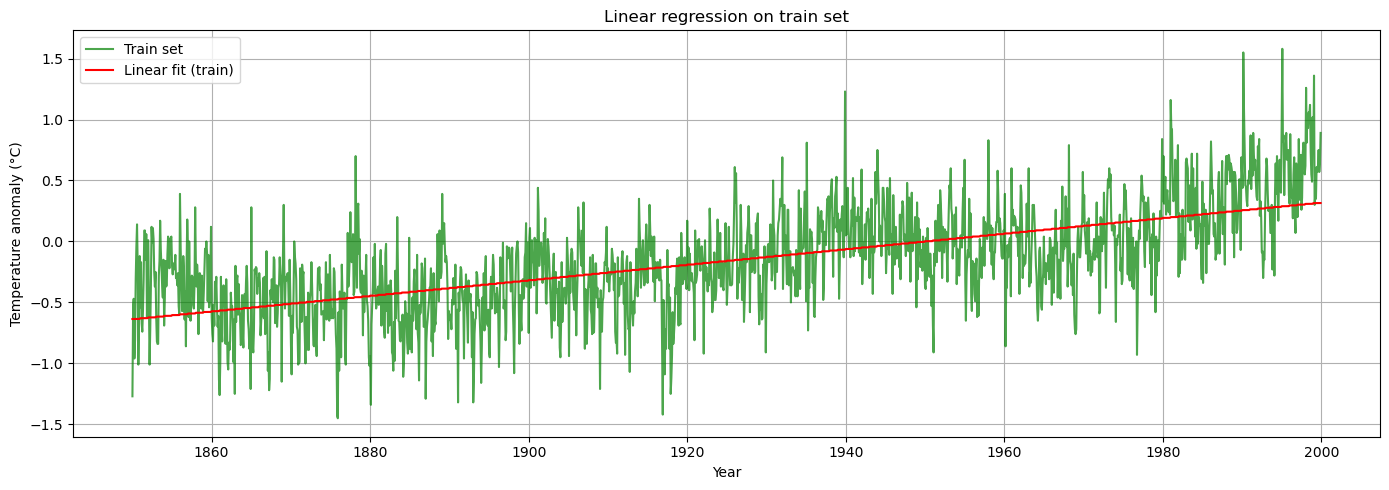

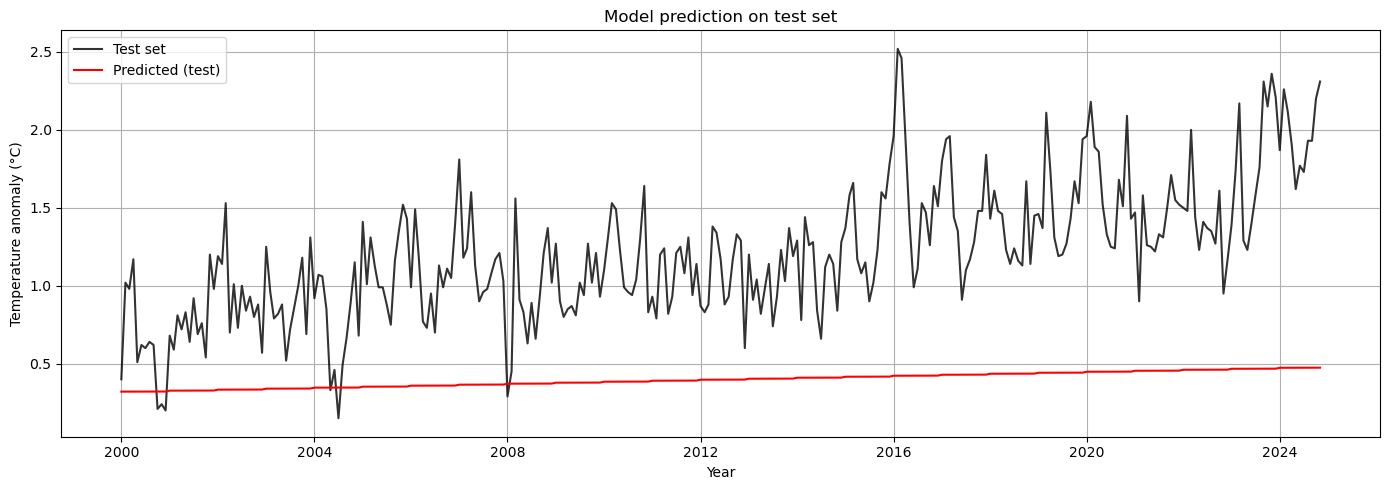

In [74]:
y_train_pred = X_train @ w

X_test = np.column_stack((np.ones(Ntest), test[:, 0]))
y_test = test[:, 1]
y_test_pred = X_test @ w
test_dates = [convert_date(d) for d in test[:, 0]]

plt.figure(figsize=(14, 5))
plt.plot(dates, y_train, label='Train set', color='green', alpha=0.7)
plt.plot(dates, y_train_pred, label='Linear fit (train)', color='red')
plt.title('Linear regression on train set')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test, label='Test set', color='black', alpha=0.8)
plt.plot(test_dates, y_test_pred, label='Predicted (test)', color='red')
plt.title('Model prediction on test set')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Residuals analysis on train and test sets

To evaluate the performance of our model, we analyze the residuals (the difference between the observed and predicted temperature anomalies). 

We calculate the residuals for both the training and test sets:

In [77]:
# residuals
residuals_test = y_test - y_test_pred
residuals_train = y_train - y_train_pred

Then, we plot the residuals over time to visually inspect for any patterns:

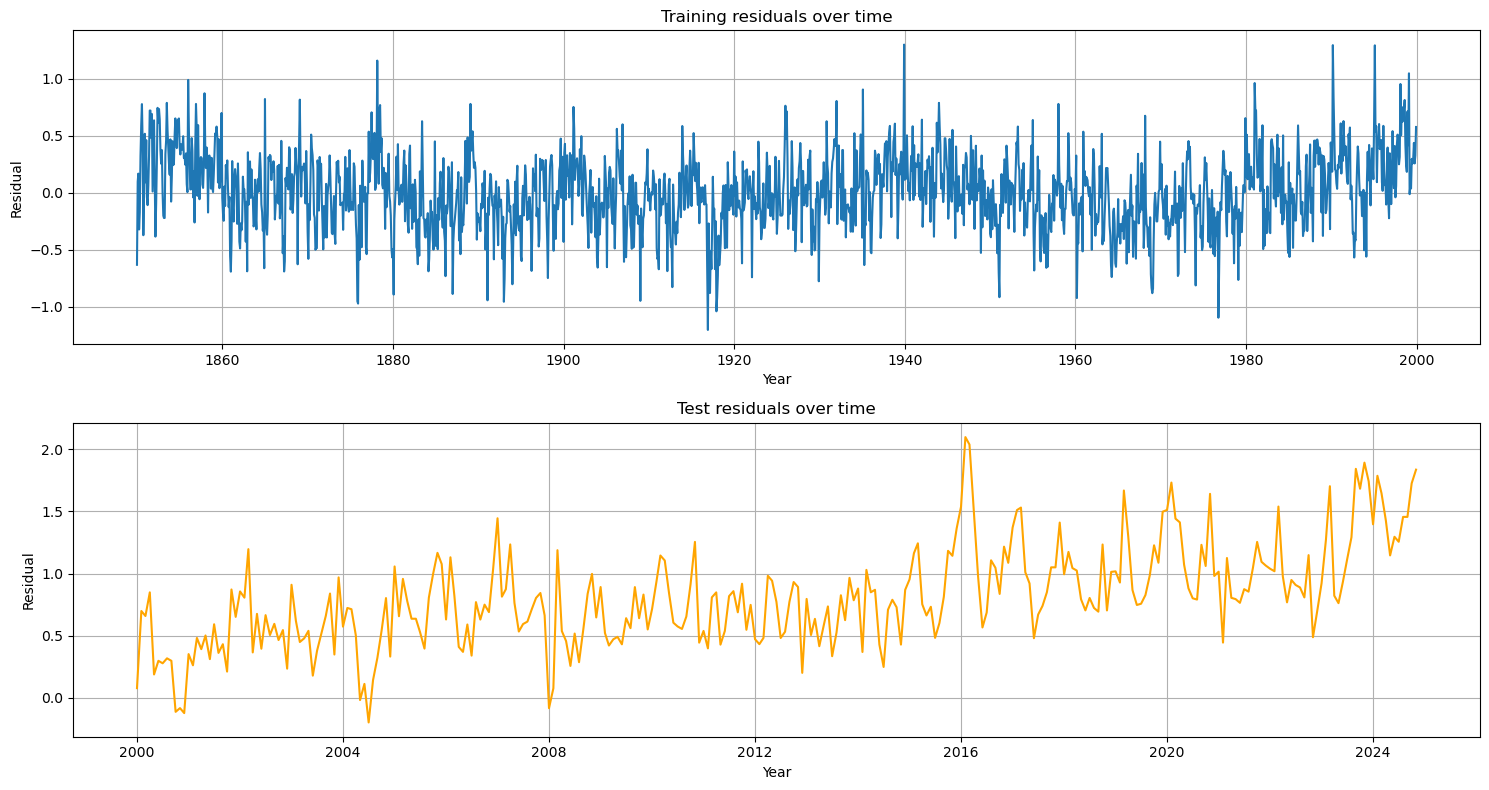

In [80]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(dates, residuals_train)
axes[0].set_title("Training residuals over time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Residual")
axes[0].grid(True)

axes[1].plot(test_dates, residuals_test, color='orange')
axes[1].set_title("Test residuals over time")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Residual")
axes[1].grid(True)
plt.tight_layout()
plt.show()

## Histogram of residuals

We can further examine the residuals by plotting histograms to check their distribution. Under the assumptions of linear regression, residuals should follow a normal distribution with a mean of zero.

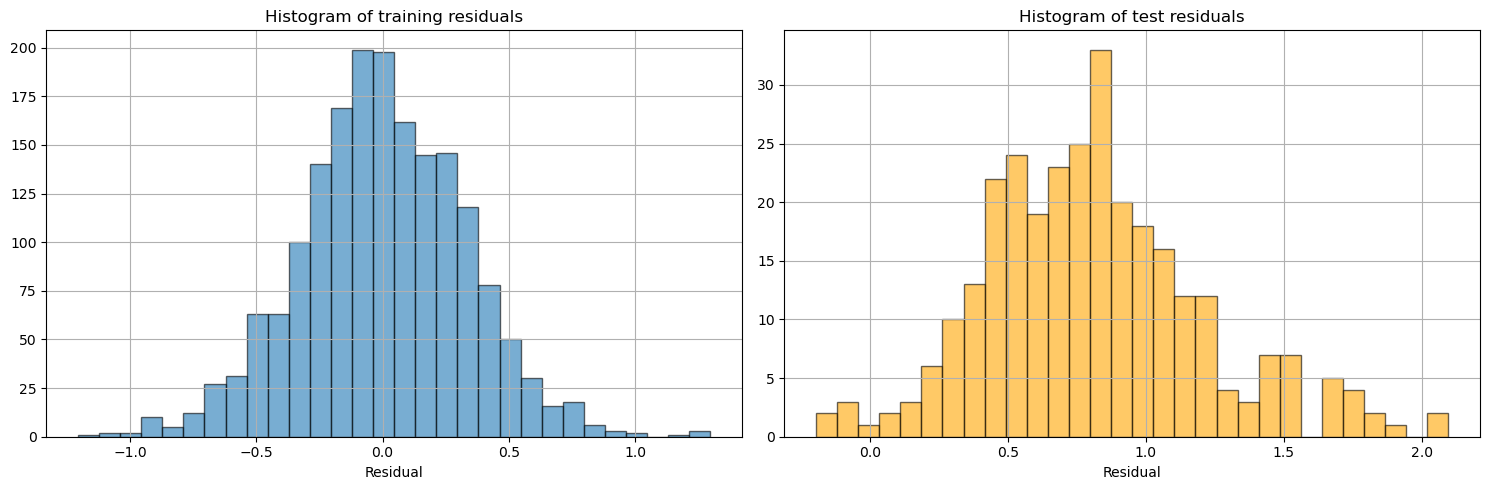

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(residuals_train, bins=30, edgecolor='black', alpha=0.6)
axes[0].set_title("Histogram of training residuals")
axes[0].set_xlabel("Residual")
axes[0].grid(True)

axes[1].hist(residuals_test, bins=30, edgecolor='black', alpha=0.6, color='orange')
axes[1].set_title("Histogram of test residuals")
axes[1].set_xlabel("Residual")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Statistical tests

In this section, we perform several statistical tests to assess the validity and reliability of the linear regression model. We focus on the following:

- Confidence intervals for the regression parameters (intercept and slope)

- Hypothesis testing for the slope to check if it is significantly different from zero

- Confidence intervals for predictions on both the training and test sets

- Analysis of residuals to check for normality and goodness-of-fit

## Confidence intervals for the regression parameters

Confidence intervals provide a range of values that are likely to contain the true value of the model parameters (intercept and slope) with a certain level of confidence, typically 95%. To compute the confidence intervals, we use the standard errors of the estimated parameters, which are derived from the covariance matrix of the regression coefficients.

The formula for the confidence interval for each parameter is: $CI = \hat{w} \pm t_{1-\alpha/2,n-p}*SE $. Where:
- $\hat{w}$ is the estimated regression parameter (intercept or slope)
- $t_{1-\alpha/2,n-p}$ is the critical t-value from the t-distribution for a 95% confidence level and the degrees of freedom  n-p
- $SE$ is the standard error of the parameter

We calculate the confidence intervals for both the intercept and slope as follows:

In [87]:
# calculate standard errors of the coefficients
n, p = X_train.shape
dof = n - p # degrees of freedom (n: samples, p: parameters)

residual_variance = np.sum(residuals_train**2) / dof # estimate variance of residuals

# covariance matrix of w
XTX_inv = np.linalg.inv(X_train.T @ X_train)
cov_w = residual_variance * XTX_inv

# standard errors of coefficients
se_w = np.sqrt(np.diag(cov_w))

# t-critical value for 95% confidence
alpha = 0.05
t_crit = t.ppf(1 - alpha/2, df=dof)

# confidence intervals
ci_lower = w - t_crit * se_w
ci_upper = w + t_crit * se_w

print("95% confidence intervals for the parameters:")
print(f"{'Intercept'}: {w[0]:.6f} ± {t_crit * se_w[0]:.6f} → [{ci_lower[0]:.6f}, {ci_upper[0]:.6f}]")
print(f"{'Slope'}: {w[1]:.6f} ± {t_crit * se_w[1]:.6f} → [{ci_lower[1]:.6f}, {ci_upper[1]:.6f}]")

95% confidence intervals for the parameters:
Intercept: -12.435443 ± 0.677321 → [-13.112764, -11.758122]
Slope: 0.000064 ± 0.000004 → [0.000060, 0.000067]


## Hypothesis testing for the slope

We perform a hypothesis test to determine whether the slope of the regression line is significantly different from zero.

- $H_0$: slope = 0

- $H_1$: slope $\neq$ 0

To test this, we compute the t-statistic for the estimated slope:


$t = \frac{\hat{w_1}}{SE(\hat{w_1})}$

Where:
- $\hat{w_1}$ is the estimated slope,
- $SE(\hat{w_1})$ is the standard error of the slope.

We then calculate the p-value associated with this statistic, using the Student’s t-distribution with n-p degrees of freedom.

- If the p-value is less than $\alpha = 5 \%$, we reject the null hypothesis.
- Otherwise, we fail to reject the null hypothesis.


In [90]:
# t-statistic for slope
t_slope = w[1] / se_w[1]
p_value = 2 * (1 - t.cdf(np.abs(t_slope), df=dof))

print(f"Slope t-statistic: {t_slope}")
print(f"p-value: {p_value}")

if p_value < alpha:
    print("We reject the null hypothesis: the slope is significantly different from zero.")
else:
    print("We fail to reject the null hypothesis: the slope is not significantly different from zero.")

Slope t-statistic: 35.552992431148546
p-value: 0.0
We reject the null hypothesis: the slope is significantly different from zero.


Since the p-value is below the 0.05 significance level, we reject the null hypothesis and conclude that the slope is significantly different from zero.

## Confidence intervals for predictions

Next, we calculate 95% prediction intervals for both the training and test sets. Prediction intervals take into account both the uncertainty in the model parameters and the inherent variability of the data. This gives a range within which we expect new observations to fall, with 95% confidence.


The prediction interval at a point $x_0$ is given by:

$\hat{y}(x_0) \pm t_{1-\alpha/2, \, n - p} * \sqrt{ \hat{\sigma}^2 \left(1 + x_0^\top (X^\top X)^{-1} x_0 \right) }
$

Where:
- $\hat{y}(x_0)$ is the predicted value
- $\hat{\sigma}^2$ is the residual variance estimate
- $x_0$ is the row vector corresponding to the input (including the bias term)

We define a function to compute the prediction intervals:

In [93]:
def prediction_interval(X, y_pred, X_base, se_squared, t_crit):
    XTX_inv = np.linalg.inv(X_base.T @ X_base)
    pred_var = np.sum(X @ XTX_inv * X, axis=1) + 1  # includes model + noise
    margin = t_crit * np.sqrt(se_squared * pred_var)
    return y_pred - margin, y_pred + margin

# train prediction intervals
train_lower, train_upper = prediction_interval(X_train, y_train_pred, X_train, residual_variance, t_crit)

# test prediction intervals
test_lower, test_upper = prediction_interval(X_test, y_test_pred, X_train, residual_variance, t_crit)

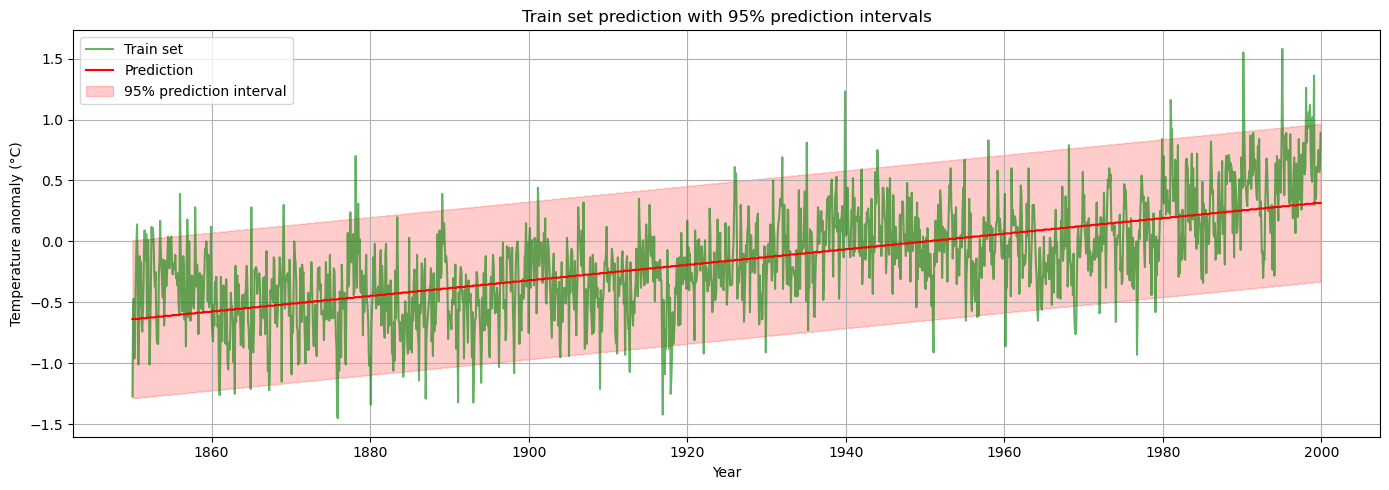

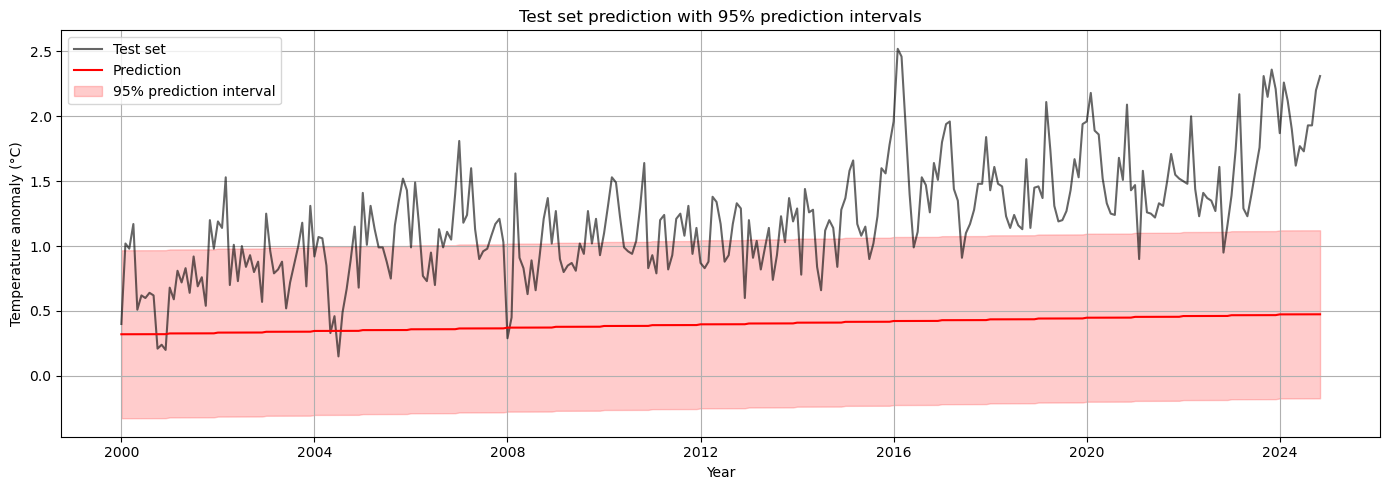

In [95]:
# plot on training data
plt.figure(figsize=(14, 5))
plt.plot(dates, y_train, label='Train set', alpha=0.6, color='green')
plt.plot(dates, y_train_pred, label='Prediction', color='red')
plt.fill_between(dates, train_lower, train_upper, color='red', alpha=0.2, label='95% prediction interval')
plt.title('Train set prediction with 95% prediction intervals')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot on test data
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test, label='Test set', alpha=0.6, color='black')
plt.plot(test_dates, y_test_pred, label='Prediction', color='red')
plt.fill_between(test_dates, test_lower, test_upper, color='red', alpha=0.2, label='95% prediction interval')
plt.title('Test set prediction with 95% prediction intervals')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We combined the training and test sets into a single plot to visualize the model’s predictions across the entire time range, including the associated 95% prediction intervals.

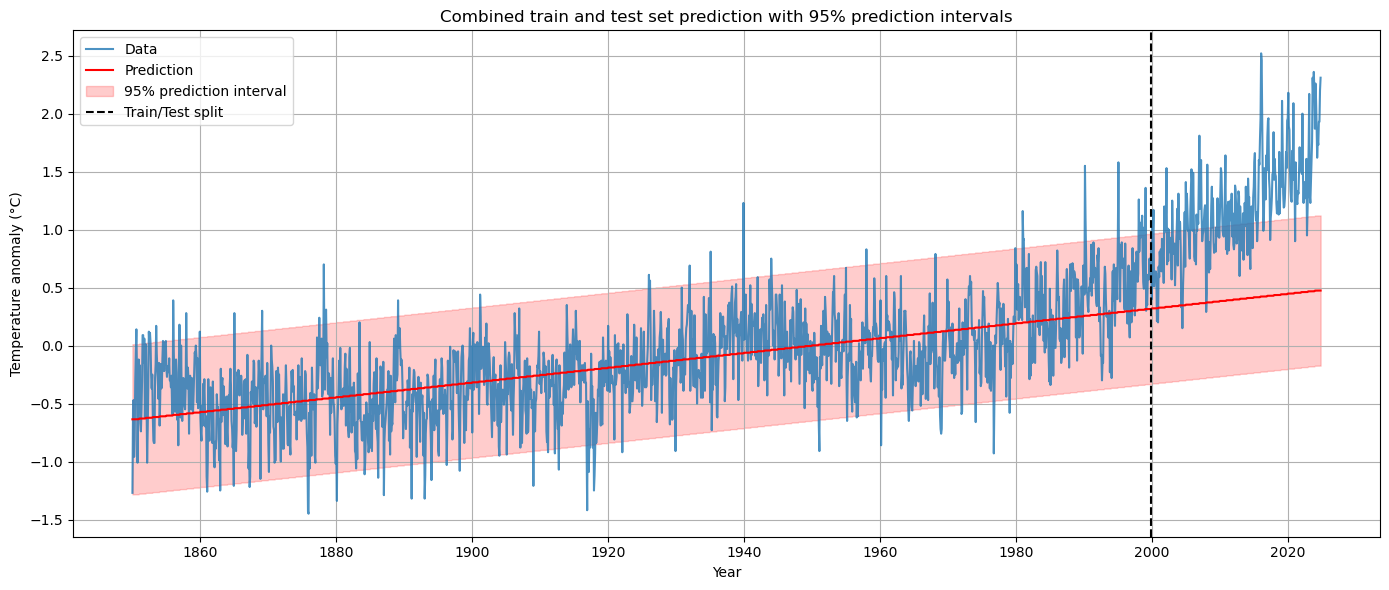

In [97]:
all_dates = np.concatenate([dates, test_dates])
all_y = np.concatenate([y_train, y_test])
all_pred = np.concatenate([y_train_pred, y_test_pred])
all_lower = np.concatenate([train_lower, test_lower])
all_upper = np.concatenate([train_upper, test_upper])

# plot combined
plt.figure(figsize=(14, 6))
plt.plot(all_dates, all_y, label='Data', alpha=0.8)
plt.plot(all_dates, all_pred, label='Prediction', color='red')
plt.fill_between(all_dates, all_lower, all_upper, color='red', alpha=0.2, label='95% prediction interval')

# vertical line to mark split
split_year = dates[-1]
plt.axvline(split_year, color='black', linestyle='--', alpha=1, label='Train/Test split')

plt.title('Combined train and test set prediction with 95% prediction intervals')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Analysis of residuals: normality, goodness of fit...

Finally, we examine the residuals for normality using the Shapiro-Wilk test, which tests the null hypothesis that the residuals are normally distributed. If the residuals are normally distributed, it supports the validity of the regression model.

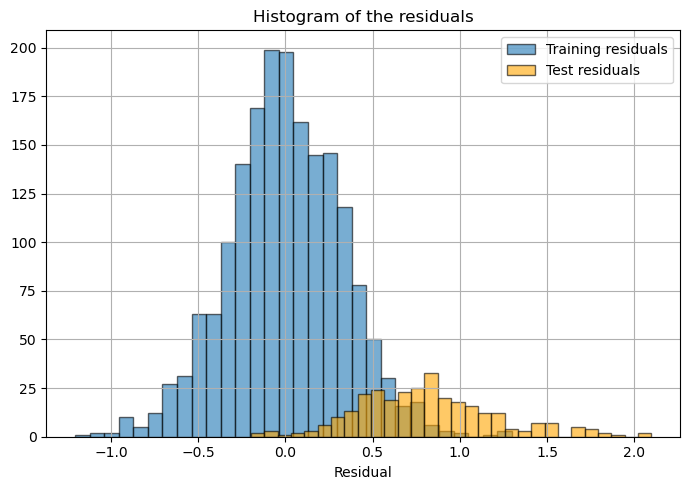

In [100]:
plt.figure(figsize=(7, 5))
plt.hist(residuals_train, bins=30, edgecolor='black',alpha=0.6,label='Training residuals')
plt.hist(residuals_test, bins=30, edgecolor='black', alpha=0.6,label='Test residuals',color='orange')
plt.title("Histogram of the residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Under the assumptions of linear regression, residuals should be normally distributed with zero mean and constant variance (cf. linear regression course **$H_3$ homoscedasticity**). 

In [119]:
# train residuals
shapiro_train = st.shapiro(residuals_train)
print("Train residuals - Shapiro-Wilk p-value:", shapiro_train.pvalue)
# test residuals
shapiro_test = st.shapiro(residuals_test)
print("Test residuals - Shapiro-Wilk p-value:", shapiro_test.pvalue)

Train residuals - Shapiro-Wilk p-value: 0.002321828940993568
Test residuals - Shapiro-Wilk p-value: 0.000500556795222591


The test residuals have a p-value much lower than 0.05, indicating a significant deviation from normality.

weights [intercept, slope]: [-2.30408332e-12  1.19462410e-17]


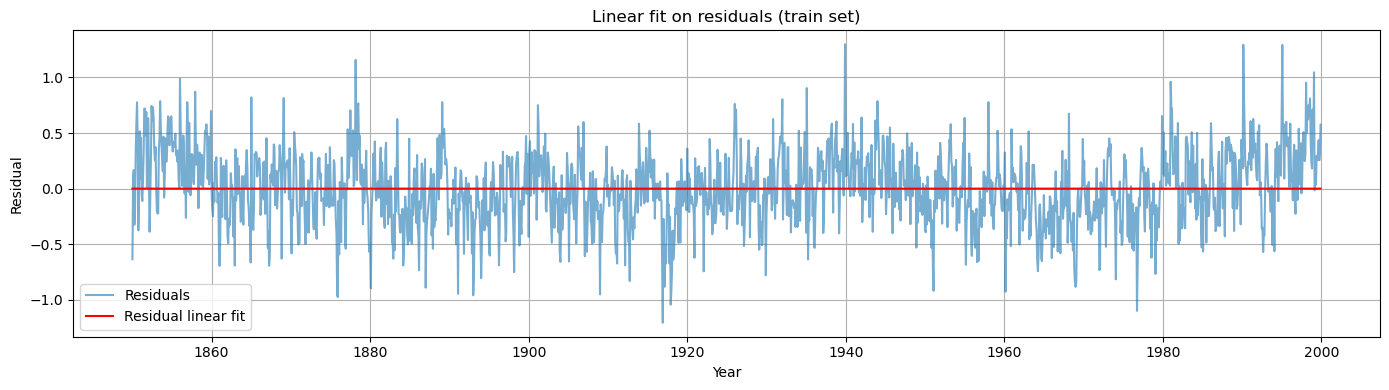

In [107]:
X_resid = np.column_stack((np.ones_like(train[:, 0]), train[:, 0]))
resid_fit = linear_regression(X_resid, residuals_train)
print("weights [intercept, slope]:", resid_fit)

# predicted residuals
resid_pred = X_resid @ resid_fit

plt.figure(figsize=(14, 4))
plt.plot(dates, residuals_train, label='Residuals', alpha=0.6)
plt.plot(dates, resid_pred, color='red', label='Residual linear fit')
plt.title("Linear fit on residuals (train set)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The linear regression on the residuals yielded an intercept close to zero and a slope of approximately $1.19×10^{−17}$, indicating no significant linear trend over time. This suggests that the residuals behave randomly and that the linear model is well-specified with respect to time.

# On smaller periods

In this section, we investigate whether the rate of temperature anomaly change has varied over different historical periods. To do this, we split the dataset into smaller time windows and fit separate linear regression models for each period. This allows us to assess if the trends in temperature anomalies differ across different epochs.

## Linear regression on subsets of data

We divide the time span of the dataset into four distinct periods to better understand the variation in temperature anomalies. The time windows we consider are:

- 1840–1880

- 1880–1920

- 1920–1960

- 1960–2020

For each of these windows, we perform linear regression to estimate the rate of change in temperature anomalies. By fitting individual models to each period, we can visually assess whether the rate of warming (or cooling) has increased, decreased, or remained stable over time.

The following code performs linear regression for each time period and overlays the resulting fits on the dataset:

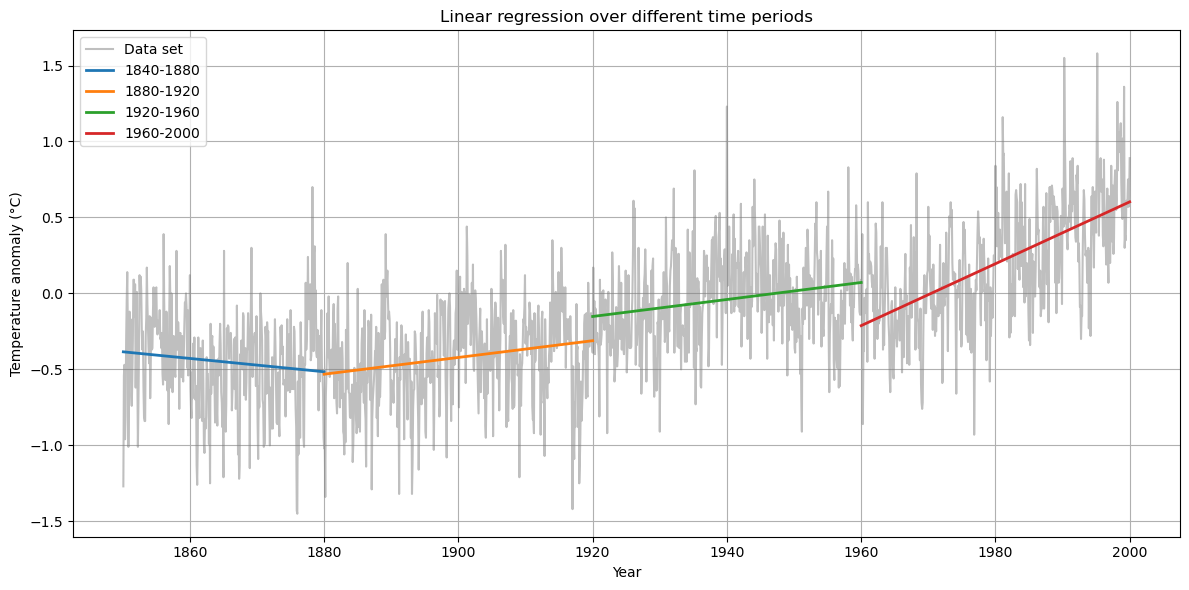

In [122]:
float_years = np.array([d.year + d.month / 12 for d in dates])

# time window
windows = [(1840, 1880), (1880, 1920), (1920, 1960), (1960, 2000)]

plt.figure(figsize=(12, 6))
plt.plot(float_years, y_train, color='gray', alpha=0.5, label='Data set')

for (start, end) in windows:
    mask = (float_years >= start) & (float_years <= end)
    t_sub = float_years[mask]
    y_sub = y_train[mask]

    X_sub = np.vstack([np.ones_like(t_sub), t_sub]).T
    y_sub_vec = y_sub.reshape(-1, 1)
    theta_sub = np.linalg.inv(X_sub.T @ X_sub) @ X_sub.T @ y_sub_vec
    y_fit = X_sub @ theta_sub

    plt.plot(t_sub, y_fit, linewidth=2, label=f'{start}-{end}')

plt.xlabel("Year")
plt.ylabel("Temperature anomaly (°C)")
plt.title("Linear regression over different time periods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretation of the Results

1. **Early Period (1840–1880):**  
   The linear fit for this period shows a slightly **negative slope**, indicating a small cooling trend rather than stability. This could reflect natural climate variability before major industrial activity had a measurable impact on global temperatures.

2. **Mid Periods (1880–1920, 1920–1960):**  
   The fits for these periods show a **mild warming trend**. While not as pronounced as in recent decades, the gradual increase in temperature anomalies may indicate early signs of human influence or natural climate cycles.

3. **Recent Period (1960–2020):**  
   The linear fit shows a **strong and steep upward slope**, indicating a significant **acceleration in warming**. This period aligns with rapid industrialization, increased fossil fuel consumption and rising greenhouse gas emissions.


# Breakpoints

In this section, we assume that the global temperature anomaly data may contain one or more structural changes over time, referred to as breakpoints. These breakpoints represent years when the rate of warming (or cooling) may have changed significantly. To identify these breakpoints, we fit piecewise linear regression models, which allow us to model different segments of the data with separate linear trends.

We will start by fitting models with one breakpoint (two segments) and then extend the analysis to models with two breakpoints (three segments). This approach enables us to investigate whether the temperature anomaly data exhibits significant changes in trend over different periods.

## Fit linear models with one change point

To begin, we search for the best breakpoint by iterating through a range of possible years. For each potential breakpoint, we split the data into two segments and fit a linear model to each segment. We then calculate the residual sum of squares (RSS) for each model, and the breakpoint corresponding to the minimum RSS is considered the best breakpoint.

The following code implements this procedure:

In [129]:
# use float_years and y_train from before
start_year = int(float_years.min())   
end_year = int(float_years.max())
year_range = float_years[(float_years >= start_year) & (float_years <= end_year)]
anomaly_range = y_train[(float_years >= start_year) & (float_years <= end_year)]

def fit_linear(x, y):
    X = np.vstack([np.ones_like(x), x]).T
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    y_pred = X @ w
    rss = np.sum((y - y_pred)**2)
    return w, y_pred, rss

In [131]:
breaks = np.arange(start_year, end_year, 1)
rss_total = []

for b in breaks:
    # split data
    mask_left = year_range <= b
    mask_right = year_range > b

    x1, y1 = year_range[mask_left], anomaly_range[mask_left]
    x2, y2 = year_range[mask_right], anomaly_range[mask_right]

    if len(x1) < 10 or len(x2) < 10:
        rss_total.append(np.inf)
        continue

    _, _, rss1 = fit_linear(x1, y1)
    _, _, rss2 = fit_linear(x2, y2)
    rss_total.append(rss1 + rss2)

# best change point = minimum RSS
best_break = breaks[np.argmin(rss_total)]
print(f"Best change point year: {best_break}")

Best change point year: 1964


The best breakpoint year is found to be **1964**.

We now fit a piecewise linear model with this breakpoint and visualize the results:

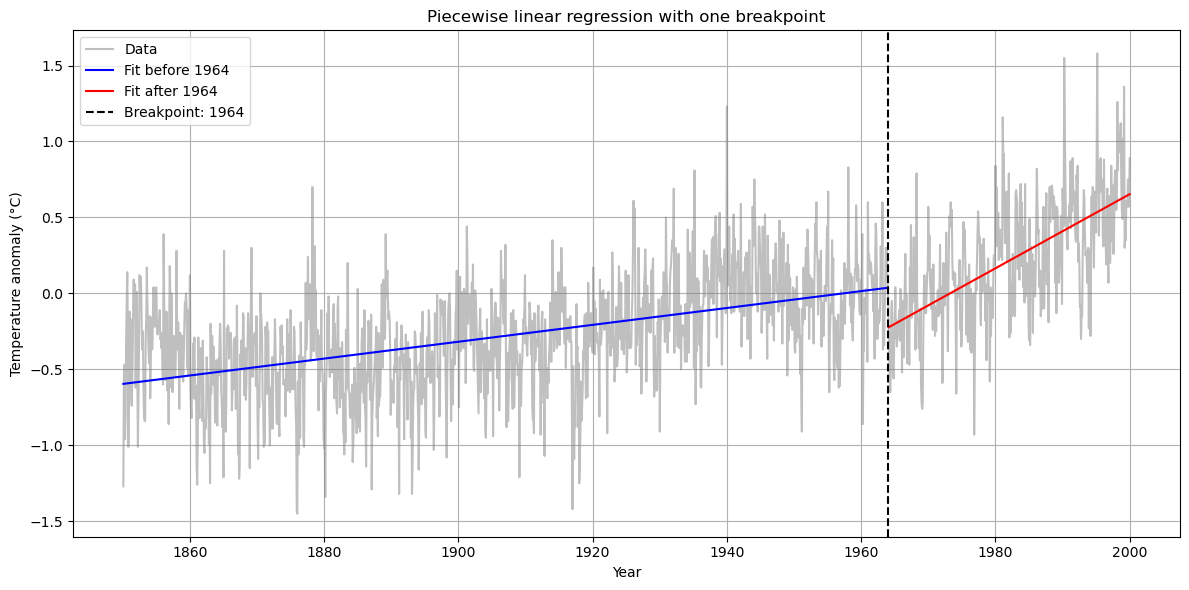

In [133]:
# split and fit on best breakpoint
mask1 = year_range <= best_break
mask2 = year_range > best_break

x1, y1 = year_range[mask1], anomaly_range[mask1]
x2, y2 = year_range[mask2], anomaly_range[mask2]

w1, y_fit1, _ = fit_linear(x1, y1)
w2, y_fit2, _ = fit_linear(x2, y2)

# plot
plt.figure(figsize=(12, 6))
plt.plot(year_range, anomaly_range, color='gray', alpha=0.5, label='Data')
plt.plot(x1, y_fit1, color='blue', label=f'Fit before {best_break}')
plt.plot(x2, y_fit2, color='red', label=f'Fit after {best_break}')
plt.axvline(x=best_break, color='black', linestyle='--', label=f'Breakpoint: {best_break}')
plt.title('Piecewise linear regression with one breakpoint')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
print(f"Slope before {best_break}: {w1[1]}")
print(f"Slope after {best_break}: {w2[1]}")

Slope before 1964: 0.00555300684925868
Slope after 1964: 0.024399279117250865


The plot shows two distinct linear segments: one before 1964 (blue) and one after 1964 (red), with a significant change in the slope of the temperature anomaly trend around 1964.

The estimated slope before 1964 is **0.0056 °C per year**, while the slope after 1964 increases to **0.0244 °C per year**. This indicates a threefold acceleration in the rate of temperature anomalies after the breakpoint.

## Extend to two segments

Next, we extend the analysis to include two breakpoints, which will result in three segments. To identify the two breakpoints, we iterate through pairs of candidate years and split the data into three segments. We then fit a linear model to each segment and calculate the total RSS. The two breakpoints that minimize the total RSS are selected as the optimal breakpoints.

In [89]:
start_year = int(float_years.min())   
end_year = int(float_years.max())

candidate_years = np.arange(start_year, end_year + 1, 1)
min_segment_length = 30

best_rss = np.inf
best_breaks = (None, None)

for i in range(len(candidate_years)):
    for j in range(i + 1, len(candidate_years)):
        bp1, bp2 = candidate_years[i], candidate_years[j]
        
        if (bp2 - bp1 < min_segment_length) or (bp1 - start_year < min_segment_length) or (end_year - bp2 < min_segment_length):
            continue
        
        # split data
        mask1 = float_years <= bp1
        mask2 = (float_years > bp1) & (float_years <= bp2)
        mask3 = float_years > bp2

        x1, y1 = float_years[mask1], y_train[mask1]
        x2, y2 = float_years[mask2], y_train[mask2]
        x3, y3 = float_years[mask3], y_train[mask3]

        if min(len(x1), len(x2), len(x3)) < 10:
            continue

        # fitting by least square
        _, _, rss1 = fit_linear(x1, y1)
        _, _, rss2 = fit_linear(x2, y2)
        _, _, rss3 = fit_linear(x3, y3)

        total_rss = rss1 + rss2 + rss3
        if total_rss < best_rss:
            best_rss = total_rss
            best_breaks = (bp1, bp2)

# final result
print("Best 2 breakpoints (min 30 years/segment):", best_breaks)

Best 2 breakpoints (min 30 years/segment): (1888, 1964)


The best two breakpoints are 1888 and 1964.

Now, we split the data at these two breakpoints and fit piecewise linear regression models to each of the three segments:

In [92]:
# final fit with the best breakpoints
bp1, bp2 = best_breaks

mask1 = float_years <= bp1
mask2 = (float_years > bp1) & (float_years <= bp2)
mask3 = float_years > bp2

x1, y1 = float_years[mask1], y_train[mask1]
x2, y2 = float_years[mask2], y_train[mask2]
x3, y3 = float_years[mask3], y_train[mask3]

w1, y_fit1, _ = fit_linear(x1, y1)
w2, y_fit2, _ = fit_linear(x2, y2)
w3, y_fit3, _ = fit_linear(x3, y3)

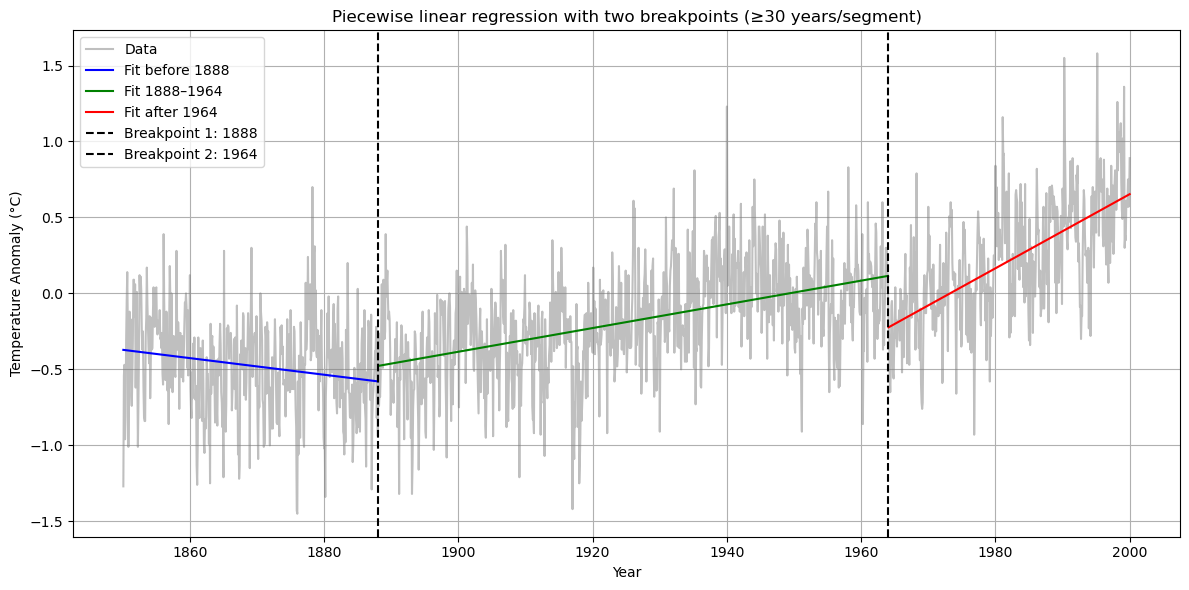

Slope before 1888: -0.0054674018829448
Slope 1888–1964: 0.007798694080442042
Slope after 1964: 0.024399279117250865


In [94]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(float_years, y_train, color='gray', alpha=0.5, label='Data')

plt.plot(x1, y_fit1, color='blue', label=f'Fit before {bp1}')
plt.plot(x2, y_fit2, color='green', label=f'Fit {bp1}–{bp2}')
plt.plot(x3, y_fit3, color='red', label=f'Fit after {bp2}')

plt.axvline(bp1, color='black', linestyle='--', label=f'Breakpoint 1: {bp1}')
plt.axvline(bp2, color='black', linestyle='--', label=f'Breakpoint 2: {bp2}')

plt.title('Piecewise linear regression with two breakpoints (≥30 years/segment)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Slope before {bp1}: {w1[1]}")
print(f"Slope {bp1}–{bp2}: {w2[1]}")
print(f"Slope after {bp2}: {w3[1]}")

## Interpretation of the piecewise linear model with two breakpoints

1. **Before 1888**  
   The estimated slope is **–0.0055 °C per year**. It indicates a slight cooling trend during this period. This trend is consistent with the tail end of the Little Ice Age, a period of relatively low global temperatures spanning roughly from the 14th to the 19th century. The negative slope may also reflect natural variability in the climate system prior to widespread industrialization.

2. **From 1888 to 1964**  
   The slope increases to **+0.0078 °C per year**. It marks the beginning of a warming trend. This period corresponds to early industrial development.

3. **After 1964**  
   The slope rises sharply to **+0.0244 °C per year**. It indicates a **strong acceleration in global warming**. This inflection point aligns with the post-World War II industrial boom and a significant increase in greenhouse gas emissions.

# Conclusion

In this project, we analyzed global temperature anomaly data using linear regression techniques to investigate long-term climate trends and structural changes in the rate of global warming.

We started with a simple linear regression model to capture the overall warming trend. While this model provided a general view of increasing temperatures, it failed to account for potential shifts in the rate of change over time.

To address this limitation, we implemented piecewise linear regression models with one and two breakpoints. We identified two statistically optimal breakpoints in 1888 and 1964. These breakpoints divide the data into three meaningful periods:

- A slight cooling trend before 1888, consistent with the end of the Little Ice Age
- A modest warming phase between 1888 and 1964, corresponding to early industrialization
- A sharp acceleration in warming after 1964, aligning with the rise of large-scale greenhouse gas emissions

This segmented approach provided a more accurate and interpretable model of global temperature evolution, highlighting that the warming trend is not constant, but has intensified significantly in recent decades. Finally, the project confirms the presence of **non-linear structural changes** in global temperature anomalies and supports the scientific consensus on the human-driven acceleration of climate change.